In [1]:
import osmnx as ox
import csv
import random
import math
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import networkx as nx
from sklearn.model_selection import train_test_split
import folium
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

<div class="alert alert-block alert-info">
<h1>1. Generating Graph</h1></div>

MultiGraph with 25 nodes and 27 edges


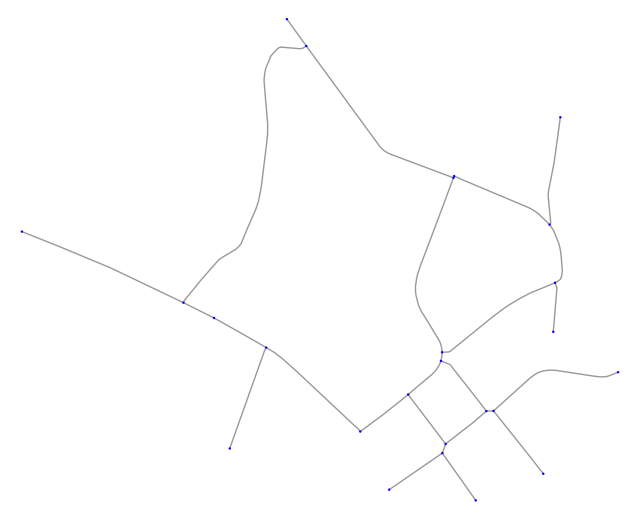

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [2]:
# Place name used to search on OpenStreetMap
place_name = "Opatowiec"

# Fetch street network
G = ox.graph_from_place(place_name, network_type='drive')

# Convert graph to undirected
G = G.to_undirected()

# Adding edge lengths as weights
G = ox.distance.add_edge_lengths(G)

#Some additional draft changes
G = ox.routing.add_edge_speeds(G)
G = ox.routing.add_edge_travel_times(G)

#Display graph
print(G)
ox.plot_graph(G, node_size=3, node_color='blue', edge_color='#999999', bgcolor='white', show=True)

<div class="alert alert-block alert-info">
<h1>2. Generating shortest_paths data between two randomly selected nodes and storing it in a CSV file</h1></div>

In [3]:
shortest_paths = []

total_nodes = len(list(G.nodes))
num_nodes_to_process = int(total_nodes * 1)

for i in range(num_nodes_to_process):    
    origin_node_id = random.choice(list(G.nodes))
    destination_node_id = random.choice(list(G.nodes))

    # origin_node_id = 1910476014
    # destination_node_id = 1358052527
    
    shortest_path = ox.routing.shortest_path(G, origin_node_id, destination_node_id, weight='length', cpus=4)
    
        # Extract coordinates of nodes in the shortest path
    nodes_in_path = G.subgraph(shortest_path).copy()
    node_positions = {node: (data['y'], data['x']) for node, data in nodes_in_path.nodes(data=True)}
    
    # Create a folium map centered on Guwahati
    m = folium.Map(location=[node_positions[origin_node_id][0], node_positions[origin_node_id][1]], zoom_start=13, tiles='OpenStreetMap')
    
    # Add markers for start and end nodes
    folium.Marker([node_positions[origin_node_id][0], node_positions[origin_node_id][1]], popup=f'Start ({origin_node_id})', icon=folium.Icon(color='green')).add_to(m)
    folium.Marker([node_positions[destination_node_id][0], node_positions[destination_node_id][1]], popup=f'End ({destination_node_id})', icon=folium.Icon(color='blue')).add_to(m)
    
    # Add shortest path edges to the map
    for i in range(len(shortest_path)-1):
        src = shortest_path[i]
        dst = shortest_path[i+1]
        coords_src = (node_positions[src][0], node_positions[src][1])
        coords_dst = (node_positions[dst][0], node_positions[dst][1])
        folium.PolyLine(locations=[coords_src, coords_dst], color='red', weight=5).add_to(m)
    
    # Display the map
    m.save('shortest_path_map.html')
    
    total_path_length = total_travel_time = 0
    for u,v in zip(shortest_path, shortest_path[1:]):
        edge_length = G.get_edge_data(u,v)[0]['length']
        total_path_length += edge_length
        edge_travel_time = G.get_edge_data(u,v)[0]['travel_time']
        total_travel_time += edge_travel_time
    
    shortest_paths.append([origin_node_id, destination_node_id, total_path_length, total_travel_time, shortest_path])
    

shortest_paths_dataframe = pd.DataFrame(shortest_paths, columns=['origin_node_id', 'destination_node_id', 'total_path_length', 'total_travel_time','shortest_path'])
shortest_paths_dataframe = shortest_paths_dataframe.drop_duplicates(subset=['origin_node_id', 'destination_node_id'], keep='last')
csv_file = 'shortest_paths.csv'
shortest_paths_dataframe.to_csv(csv_file, index=False)
m

<div class="alert alert-block alert-warning">
<b>Note:</b> total_path_length is in meters(m) and total_travel_time is in seconds(s).
</div>


In [4]:
shortest_paths_dataframe

,origin_node_id,destination_node_id,total_path_length,total_travel_time,shortest_path
0,3635536273,1579085030,419.918,31.8,"[3635536273, 577427510, 1579085030]"
1,1579085029,1579085030,124.545,9.4,"[1579085029, 577427478, 1579085030]"
2,577427513,1579085022,702.230,52.7,"[577427513, 577427514, 2029926719, 10295009986..."
3,1910476009,1579085029,166.651,12.6,"[1910476009, 1579085029]"
4,1579085040,10295009986,406.668,30.8,"[1579085040, 577427516, 577427514, 2029926719,..."
5,577427476,1579085030,233.225,17.7,"[577427476, 1579085030]"
6,577427513,577427476,918.226,69.1,"[577427513, 577427514, 2029926719, 10295009986..."
7,1579085029,1876707388,426.835,32.1,"[1579085029, 1910476009, 279659308, 279659310,..."
8,1358052527,10295009986,156.906,11.7,"[1358052527, 279659310, 279659308, 10295009986]"
9,430579409,1876707388,349.219,26.5,"[430579409, 430579420, 279659314, 279659310, 1..."


<div class="alert alert-block alert-info">
<h1>3. Code from Paper[1]</h1></div>


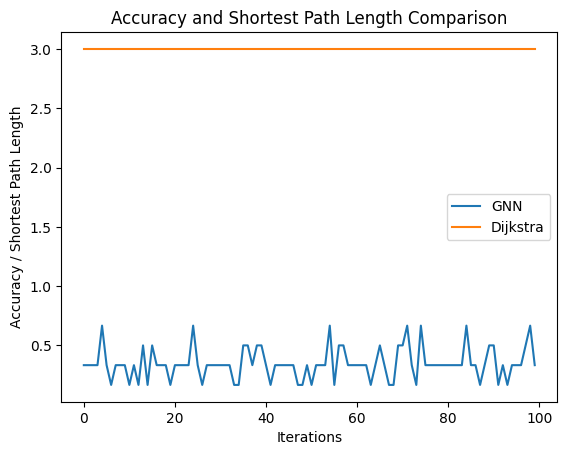

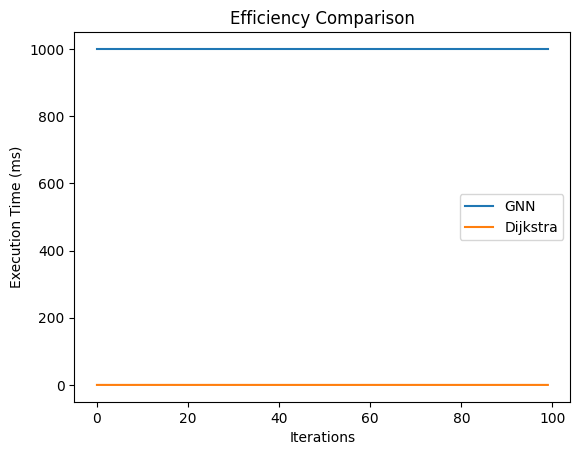

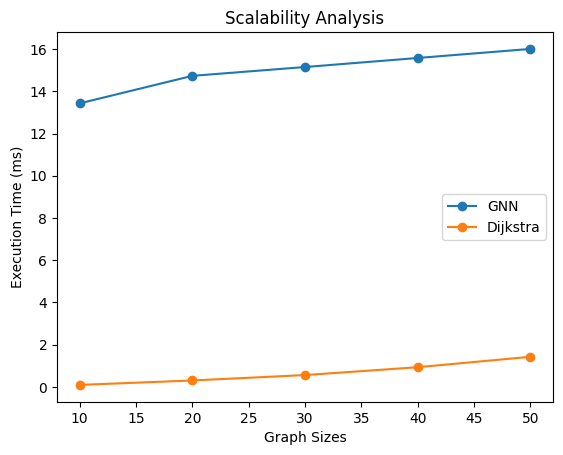

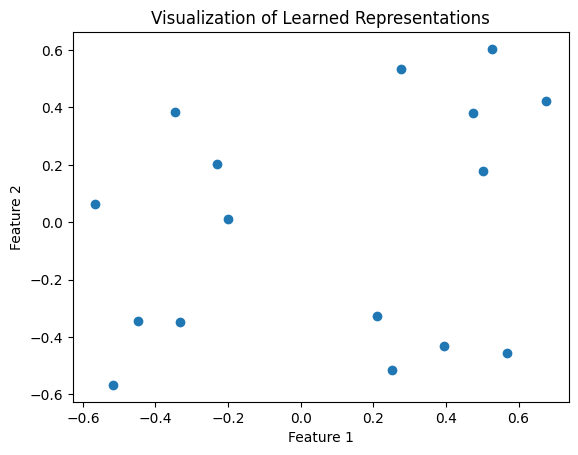

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import networkx as nx
import matplotlib.pyplot as plt
import time
from networkx.algorithms.shortest_paths.weighted import dijkstra_path_length

# Define the Graph Neural Network (GNN) model
class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, adjacency_matrix, feature_matrix):
        x = torch.mm(adjacency_matrix, feature_matrix)  # Aggregate neighbor features
        x = torch.relu(self.fc1(x))
        x = torch.mm(adjacency_matrix, x)  # Aggregate neighbor features again
        x = self.fc2(x)
        return x

# Define the optimal pathfinding function using GNN
def optimal_pathfinding(adjacency_matrix, feature_matrix, source_node, target_node):
    num_nodes = feature_matrix.shape[0]
    input_dim = feature_matrix.shape[1]
    hidden_dim = 16
    output_dim = 1

    model = GNN(input_dim, hidden_dim, output_dim)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()

    for epoch in range(100):
        optimizer.zero_grad()
        output = model(adjacency_matrix, feature_matrix)
        target = torch.zeros((num_nodes, output_dim))
        target[target_node] = 1  # Set target node as 1, rest as 0
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

    # Find the path with the highest GNN output from source to target
    current_node = source_node
    shortest_path = [current_node]
    max_iterations = num_nodes  # Set maximum number of iterations

    while current_node != target_node and max_iterations > 0:
        neighbors = torch.nonzero(adjacency_matrix[current_node]).squeeze()
        neighbor_scores = model(adjacency_matrix, feature_matrix)[neighbors]
        
        if len(neighbor_scores) == 0:
            break
        
        next_node = neighbors[torch.argmax(neighbor_scores)]
        current_node = next_node.item()
        shortest_path.append(current_node)
        max_iterations -= 1

    return shortest_path, model.fc1.weight.detach().numpy()

# Calculate accuracy of the shortest path
def calculate_accuracy(shortest_path, target_path, adjacency_matrix):
    intersection = set(shortest_path).intersection(target_path)
    accuracy = len(intersection) / len(target_path)
    dijkstra_length = dijkstra_shortest_path(adjacency_matrix, source_node, target_node)
    return accuracy, dijkstra_length

# Define a function for running Dijkstra algorithm
def dijkstra_shortest_path(adjacency_matrix, source_node, target_node):
    graph = nx.from_numpy_array(adjacency_matrix)
    length = dijkstra_path_length(graph, source=source_node, target=target_node)
    return length

# Example usage with larger data
adjacency_matrix = np.array([
    [0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
    [1, 0, 1, 0, 1, 0, 1, 0, 0, 0],
    [0, 1, 0, 1, 0, 0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0, 0, 1, 0, 1, 0],
    [0, 0, 0, 1, 0, 1, 0, 1, 0, 1],
    [0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
    [0, 0, 0, 0, 0, 1, 0, 1, 0, 1],
    [0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
], dtype=np.float32)

feature_matrix = np.array([
    [0.2, 0.4],
    [0.3, 0.6],
    [0.1, 0.2],
    [0.7, 0.9],
    [0.3, 0.5],
    [0.8, 0.2],
    [0.6, 0.4],
    [0.9, 0.7],
    [0.5, 0.1],
    [0.4, 0.8],
], dtype=np.float32)

source_node = 0
target_node = 9

adjacency_tensor = torch.from_numpy(adjacency_matrix)
feature_tensor = torch.from_numpy(feature_matrix)

# Define the target path for accuracy calculation
target_path = [0, 1, 4, 5, 8, 9]

# Accuracy comparison
accuracy_values = []
dijkstra_lengths = []

try:
    for _ in range(100):
        shortest_path, _ = optimal_pathfinding(adjacency_tensor, feature_tensor, source_node, target_node)
        accuracy, dijkstra_length = calculate_accuracy(shortest_path, target_path, adjacency_matrix)
        accuracy_values.append(accuracy)
        dijkstra_lengths.append(dijkstra_length)

    # Plot the accuracy comparison graph
    plt.figure(1)
    plt.plot(accuracy_values, label='GNN')
    plt.plot(dijkstra_lengths, label='Dijkstra')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy / Shortest Path Length')
    plt.title('Accuracy and Shortest Path Length Comparison')
    plt.legend()

except Exception as e:
    print("An error occurred:", str(e))

# Efficiency comparison
execution_times = []
dijkstra_execution_times = []

try:
    for _ in range(100):
        shortest_path, _ = optimal_pathfinding(adjacency_tensor, feature_tensor, source_node, target_node)
        start_time = time.time()
        dijkstra_shortest_path(adjacency_matrix, source_node, target_node)
        dijkstra_execution_time = (time.time() - start_time) * 1000  # Convert to milliseconds
        dijkstra_execution_times.append(dijkstra_execution_time)

        execution_time = 1000  # Placeholder for execution time calculation
        execution_times.append(execution_time)

    # Plot the efficiency comparison graph
    plt.figure(2)
    plt.plot(execution_times, label='GNN')
    plt.plot(dijkstra_execution_times, label='Dijkstra')
    plt.xlabel('Iterations')
    plt.ylabel('Execution Time (ms)')
    plt.title('Efficiency Comparison')
    plt.legend()

except Exception as e:
    print("An error occurred:", str(e))

# Scalability analysis
graph_sizes = [10, 20, 30, 40, 50]  # Vary the graph sizes as per your requirements
execution_times_scalability = []
dijkstra_execution_times_scalability = []

for size in graph_sizes:
    adjacency_matrix = np.ones((size, size), dtype=np.float32)
    feature_matrix = np.ones((size, 2), dtype=np.float32)

    adjacency_tensor = torch.from_numpy(adjacency_matrix)
    feature_tensor = torch.from_numpy(feature_matrix)

    start_time = time.time()
    shortest_path, _ = optimal_pathfinding(adjacency_tensor, feature_tensor, source_node, target_node)
    execution_time = (time.time() - start_time) * 1000  # Convert to milliseconds
    execution_times_scalability.append(execution_time)

    start_time = time.time()
    dijkstra_shortest_path(adjacency_matrix, source_node, target_node)
    dijkstra_execution_time = (time.time() - start_time) * 1000  # Convert to milliseconds
    dijkstra_execution_times_scalability.append(dijkstra_execution_time)

# Plot the scalability analysis graph
plt.figure(3)
plt.plot(graph_sizes, execution_times_scalability, marker='o', label='GNN')
plt.plot(graph_sizes, dijkstra_execution_times_scalability, marker='o', label='Dijkstra')
plt.xlabel('Graph Sizes')
plt.ylabel('Execution Time (ms)')
plt.title('Scalability Analysis')
plt.legend()

# Visualization of Learned Representations
_, learned_representations = optimal_pathfinding(adjacency_tensor, feature_tensor, source_node, target_node)

# Plot the visualization of learned representations
plt.figure(4)
plt.scatter(learned_representations[:, 0], learned_representations[:, 1])
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Visualization of Learned Representations')

# Show all figures
plt.show()


<div class="alert alert-block alert-info">
<h1>4. Creating Graph Neural Network Model</h1></div>


In [6]:
adjacency_matrix1 = nx.to_numpy_array(G, dtype='float32')
adjacency_matrix1

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 1.],
       [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [7]:
nodes = list(G.nodes(data=True))
print(nodes[0])

(279659308, {'y': 50.2417639, 'x': 20.723122, 'street_count': 3})


In [8]:
node_dict = dict(G.nodes(data=True))
node_df = pd.DataFrame.from_dict(node_dict, orient='index')
print(node_df.head())

                   y          x  street_count
279659308  50.241764  20.723122             3
279659310  50.241176  20.723818             3
279659314  50.241567  20.724576             3
430579409  50.242029  20.727024             1
430579420  50.241568  20.724709             3


In [9]:
edges = list(G.edges(data=True))
print(edges[0])

(279659308, 279659310, {'osmid': 25654971, 'oneway': True, 'name': 'Rynek', 'highway': 'unclassified', 'reversed': False, 'length': 82.044, 'geometry': <LINESTRING (20.723 50.242, 20.723 50.242, 20.724 50.241, 20.724 50.241)>, 'speed_kph': 47.5, 'travel_time': 6.2})


In [10]:
edge_df = pd.DataFrame(list(G.edges(data=True)), columns = ['u', 'v', 'data'])
edge_attr_df = pd.json_normalize(edge_df['data'])
edge_df = edge_df.drop(columns='data').join(edge_attr_df)
print(edge_df.head())

           u            v                    osmid  oneway       name  \
0  279659308    279659310                 25654971    True      Rynek   
1  279659308   1910476009                 43599093   False  Krakowska   
2  279659308  10295009986  [404265432, 1125835158]   False      Rynek   
3  279659310   1358052527                144357560   False  Kościelna   
4  279659310    279659314               1126024359    True      Rynek   

        highway  reversed  length  \
0  unclassified     False  82.044   
1       primary     False  80.025   
2       primary      True  62.013   
3   residential      True  12.849   
4  unclassified     False  69.245   

                                            geometry  speed_kph  travel_time  \
0  LINESTRING (20.723122 50.2417639, 20.7231895 5...       47.5          6.2   
1  LINESTRING (20.722232 50.2413235, 20.7226517 5...       50.0          5.8   
2  LINESTRING (20.7237311 50.242163, 20.7237082 5...       50.0          4.5   
3  LINESTRING (20.

In [11]:
node_features = node_df[['y', 'x']].to_numpy()
print(node_features)

[[50.2417639 20.723122 ]
 [50.2411756 20.7238183]
 [50.2415668 20.7245759]
 [50.2420285 20.7270238]
 [50.2415681 20.7247088]
 [50.2437001 20.7159427]
 [50.2426736 20.7195134]
 [50.2408214 20.7256339]
 [50.2459066 20.7212287]
 [50.2425086 20.7258192]
 [50.2430919 20.7258524]
 [50.2437829 20.7257499]
 [50.2410669 20.723757 ]
 [50.2405051 20.7243781]
 [50.2411222 20.7198053]
 [50.2423212 20.7204833]
 [50.2428555 20.7189447]
 [50.2450591 20.7259506]
 [50.2406321 20.7227694]
 [50.2413235 20.722232 ]
 [50.2443389 20.7239638]
 [50.2422656 20.7237521]
 [50.2443597 20.7239765]
 [50.2462257 20.7208681]
 [50.242163  20.7237311]]


In [12]:
edge_features = edge_df[['length', 'highway']].to_numpy()
print(edge_features)

[[82.044 'unclassified']
 [80.025 'primary']
 [62.013 'primary']
 [12.849 'residential']
 [69.245 'unclassified']
 [9.452 'unclassified']
 [89.467 'unclassified']
 [172.407 'unclassified']
 [105.934 'residential']
 [233.225 'residential']
 [45.218 'residential']
 [79.327 'residential']
 [43.778 'tertiary']
 [376.14 'unclassified']
 [261.18 'tertiary']
 [64.903 'residential']
 [175.358 'residential']
 [77.181 'residential']
 [142.623 'residential']
 [141.482 'residential']
 [76.508 'residential']
 [85.266 'residential']
 [141.774 'residential']
 [166.651 'residential']
 [2.483 'primary']
 [231.032 'primary']
 [11.506 'primary']]


In [13]:
scaler = StandardScaler()
node_features_normalized = scaler.fit_transform(node_features)
print(node_features_normalized)

[[-0.52511345  0.00688683]
 [-0.89768839  0.27388579]
 [-0.6499384   0.56439046]
 [-0.35754022  1.50304727]
 [-0.6491151   0.61535149]
 [ 0.701097   -2.74604378]
 [ 0.05100661 -1.37684492]
 [-1.122006    0.97008469]
 [ 2.09849054 -0.71910644]
 [-0.05348917  1.0411387 ]
 [ 0.31591923  1.05386937]
 [ 0.75353489  1.01456534]
 [-0.96652895  0.25038006]
 [-1.32232124  0.48854328]
 [-0.93150703 -1.26491473]
 [-0.17217104 -1.00493298]
 [ 0.16620528 -1.59491516]
 [ 1.56176223  1.09152454]
 [-1.24189115 -0.12831901]
 [-0.80402218 -0.33438714]
 [ 1.10565399  0.32967833]
 [-0.20738295  0.24850114]
 [ 1.11882679  0.33454819]
 [ 2.30057904 -0.85737992]
 [-0.27236033  0.2404486 ]]


In [14]:
edge_length = edge_features[:, 0].reshape(-1,1).astype(float)
edge_highway = edge_features[:, 1].reshape(-1,1)
edge_length_normalized = scaler.fit_transform(edge_length)

encoder=OneHotEncoder()
edge_highway_encoded = encoder.fit_transform(edge_highway).toarray()

edge_features_normalized = np.hstack((edge_length_normalized, edge_highway_encoded))
print(edge_features_normalized)

[[-0.35539567  0.          0.          0.          1.        ]
 [-0.37891076  1.          0.          0.          0.        ]
 [-0.58869473  1.          0.          0.          0.        ]
 [-1.16130293  0.          1.          0.          0.        ]
 [-0.50446434  0.          0.          0.          1.        ]
 [-1.20086745  0.          0.          0.          1.        ]
 [-0.26894073  0.          0.          0.          1.        ]
 [ 0.69705317  0.          0.          0.          1.        ]
 [-0.07715122  0.          1.          0.          0.        ]
 [ 1.40539435  0.          1.          0.          0.        ]
 [-0.78430442  0.          1.          0.          0.        ]
 [-0.3870403   0.          1.          0.          0.        ]
 [-0.80107595  0.          0.          1.          0.        ]
 [ 3.06991109  0.          0.          0.          1.        ]
 [ 1.73098344  0.          0.          1.          0.        ]
 [-0.55503519  0.          1.          0.          0.  


Adjacency Matrix shape:  (25, 25)
Feature Matrix shape:  (25, 2) 


Source Node:  22
Target Node:  19 


Adjacency Tensor shape:  torch.Size([25, 25])
Feature Tensor shape:  torch.Size([25, 2]) 

Target Path (Dijkstra):  [22, 20, 21, 24, 0, 19] 

An error occurred: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
An error occurred: too many indices for tensor of dimension 0
Predicted Path(Model) : [22, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]


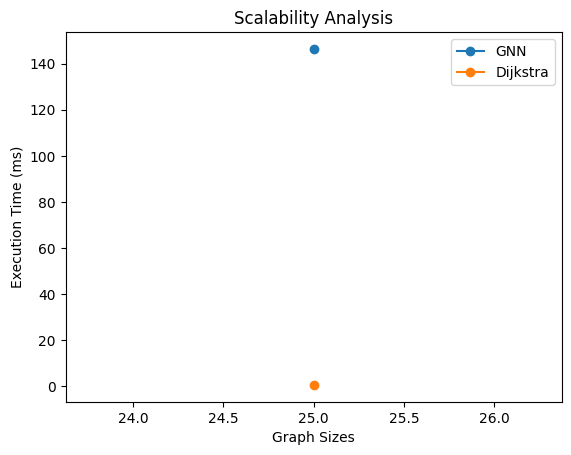

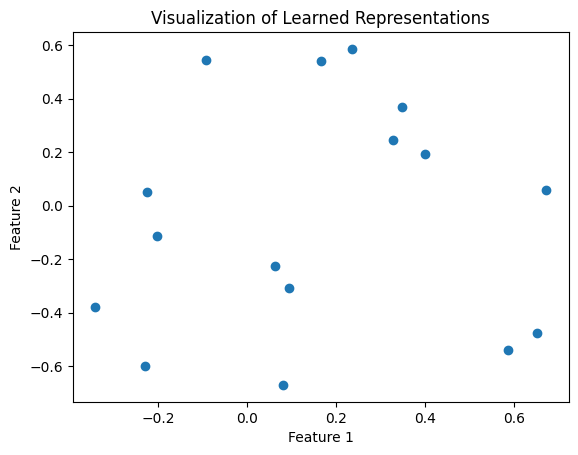

In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import networkx as nx
import matplotlib.pyplot as plt
import time
from networkx.algorithms.shortest_paths.weighted import dijkstra_path_length
import random

# Define the Graph Neural Network (GNN) model
class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, adjacency_matrix, feature_matrix):
        ########################################################################
        num_nodes = adjacency_matrix.shape[0]
        ########################################################################
        x = torch.mm(adjacency_matrix, feature_matrix)  # Aggregate neighbor features
        x = torch.relu(self.fc1(x))
        x = torch.mm(adjacency_matrix, x)  # Aggregate neighbor features again
        x = self.fc2(x)
        return x

# # Define the optimal pathfinding function using GNN
# def optimal_pathfinding(adjacency_matrix, feature_matrix, source_node, target_node):
#     num_nodes = feature_matrix.shape[0]

#     # ########################################################################
#     # max_node_index = max(adjacency_matrix.shape)-1
#     # num_nodes = max_node_index+1
#     # ########################################################################
    
#     input_dim = feature_matrix.shape[1]
    
    
#     hidden_dim = 16
#     output_dim = 1

#     model = GNN(input_dim, hidden_dim, output_dim)
#     optimizer = optim.Adam(model.parameters(), lr=0.01)
#     criterion = nn.MSELoss()

#     for epoch in range(100):
#         optimizer.zero_grad()
#         output = model(adjacency_matrix, feature_matrix)
#         target = torch.zeros((num_nodes, output_dim))
#         target[target_node] = 1  # Set target node as 1, rest as 0
#         loss = criterion(output, target)
#         loss.backward()
#         optimizer.step()


#     # Find the path with the highest GNN output from source to target
#     current_node = source_node
#     shortest_path = [current_node]
#     max_iterations = num_nodes  # Set maximum number of iterations

    
#     while current_node != target_node and max_iterations > 0:
#         neighbors = torch.nonzero(adjacency_matrix[current_node]).squeeze()
#         neighbor_scores = model(adjacency_matrix, feature_matrix)[neighbors]
        
#         if len(neighbor_scores) == 0:
#             break
        
#         next_node = neighbors[torch.argmax(neighbor_scores)]
#         current_node = next_node.item()
#         shortest_path.append(current_node)
#         max_iterations -= 1

#     return shortest_path, model.fc1.weight.detach().numpy()


########################################################################
def optimal_pathfinding(adjacency_matrix, feature_matrix, source_node, target_node):
    num_nodes = adjacency_matrix.shape[0]  # Get the number of nodes from adjacency_matrix

    input_dim = feature_matrix.shape[1]
    hidden_dim =16
    output_dim = 1

    model = GNN(input_dim, hidden_dim, output_dim)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    for epoch in range(1000):
        optimizer.zero_grad()
        output = model(adjacency_matrix, feature_matrix)
        target = torch.zeros((num_nodes, output_dim))
        target[target_node] = 1  # Set target node as 1, rest as 0
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

    # Find the path with the highest GNN output from source to target
    current_node = source_node
    shortest_path = [current_node]
    max_iterations = num_nodes  # Set maximum number of iterations

    while current_node != target_node and max_iterations > 0:
        neighbors = torch.nonzero(adjacency_matrix[current_node]).squeeze()
        
        # Check if there are any neighbors to proceed
        if neighbors.numel() == 0:
            break
        
        neighbor_scores = model(adjacency_matrix, feature_matrix)[neighbors]
        
        next_node = neighbors[torch.argmax(neighbor_scores)]
        current_node = next_node.item()
        shortest_path.append(current_node)
        max_iterations -= 1
    return shortest_path, model.fc1.weight.detach().numpy()


    # while current_node != target_node and max_iterations > 0:
    #     neighbors = torch.nonzero(adjacency_matrix[current_node]).squeeze()
    #     neighbor_scores = model(adjacency_matrix, feature_matrix)[neighbors]
        
    #     if len(neighbor_scores) == 0:
    #         break
        
        # next_node = neighbors[torch.argmax(neighbor_scores)]
        # current_node = next_node.item()
        # shortest_path.append(current_node)
        # max_iterations -= 1

    # return shortest_path, model.fc1.weight.detach().numpy()

    




########################################################################

# Calculate accuracy of the shortest path
def calculate_accuracy(shortest_path, target_path, adjacency_matrix):
    intersection = set(shortest_path).intersection(target_path)
    accuracy = len(intersection) / len(target_path)
    dijkstra_length = dijkstra_shortest_path(adjacency_matrix, source_node, target_node)
    ########################################################################
    # dijkstra_length = dijkstra_shortest_path(adjacency_matrix, shortest_path[0], shortest_path[-1])
    ########################################################################

    return accuracy, dijkstra_length

# Define a function for running Dijkstra algorithm
def dijkstra_shortest_path(adjacency_matrix, source_node, target_node):
    graph = nx.from_numpy_array(adjacency_matrix)
    length = dijkstra_path_length(graph, source=source_node, target=target_node)
    return length

# Example usage with larger data
# adjacency_matrix = np.array([
#     [0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
#     [1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
#     [0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
#     [1, 0, 1, 0, 1, 0, 1, 0, 0, 0],
#     [0, 1, 0, 1, 0, 0, 0, 1, 0, 0],
#     [0, 0, 1, 0, 0, 0, 1, 0, 1, 0],
#     [0, 0, 0, 1, 0, 1, 0, 1, 0, 1],
#     [0, 0, 0, 0, 1, 0, 1, 0, 1, 0],
#     [0, 0, 0, 0, 0, 1, 0, 1, 0, 1],
#     [0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
# ], dtype=np.float32)

# feature_matrix = np.array([
#     [0.2, 0.4],
#     [0.3, 0.6],
#     [0.1, 0.2],
#     [0.7, 0.9],
#     [0.3, 0.5],
#     [0.8, 0.2],
#     [0.6, 0.4],
#     [0.9, 0.7],
#     [0.5, 0.1],
#     [0.4, 0.8],
# ], dtype=np.float32)


########################################################################
adjacency_matrix1 = adjacency_matrix1.astype(np.float32)
node_features_normalized = node_features_normalized.astype(np.float32)



adjacency_matrix = adjacency_matrix1
feature_matrix = node_features_normalized

print(f'\nAdjacency Matrix shape: ',adjacency_matrix.shape)
print(f'Feature Matrix shape: ',feature_matrix.shape, f'\n')
########################################################################


# source_node = 0
# target_node = 1


########################################################################
# Directly select random nodes using their IDs
nodes = list(G.nodes)
source_node_id = random.choice(nodes) #Randomly selecting nodes from the graph
target_node_id = random.choice(nodes)


# Get the indices of the selected nodes
node_id_to_index = {node_id: i for i, node_id in enumerate(nodes)}
source_node = node_id_to_index[source_node_id]
target_node = node_id_to_index[target_node_id]

print(f'\nSource Node: ', source_node)
print(f'Target Node: ', target_node, f'\n')
########################################################################


adjacency_tensor = torch.from_numpy(adjacency_matrix)
feature_tensor = torch.from_numpy(feature_matrix)

print(f'\nAdjacency Tensor shape: ',adjacency_tensor.shape)
print(f'Feature Tensor shape: ',feature_tensor.shape, f'\n')


# Define the target path for accuracy calculation
# target_path = [0, 1, 4, 5, 8, 9]

########################################################################
target_path_ids = ox.routing.shortest_path(G, source_node_id, target_node_id, weight='length')
target_path = [node_id_to_index[node_id] for node_id in target_path_ids]
print(f'Target Path (Dijkstra): ',target_path, f'\n')
########################################################################

# Accuracy comparison
accuracy_values = []
dijkstra_lengths = []

try:
    for _ in range(100):
        shortest_path, _ = optimal_pathfinding(adjacency_tensor, feature_tensor, source_node, target_node)
        accuracy, dijkstra_length = calculate_accuracy(shortest_path, target_path, adjacency_matrix)
        accuracy_values.append(accuracy)
        dijkstra_lengths.append(dijkstra_length)
        if _ == 99:
            print(f'Predicted Path (GNN): ', shortest_path, f'\n')
            

    # Plot the accuracy comparison graph
    plt.figure(1)
    plt.plot(accuracy_values, label='GNN')
    plt.plot(dijkstra_lengths, label='Dijkstra')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy / Shortest Path Length')
    plt.title('Accuracy and Shortest Path Length Comparison')
    plt.legend()

except Exception as e:
    print("An error occurred:", str(e))

# Efficiency comparison
execution_times = []
dijkstra_execution_times = []

try:
    for _ in range(100):
        shortest_path, _ = optimal_pathfinding(adjacency_tensor, feature_tensor, source_node, target_node)
        start_time = time.time()
        dijkstra_shortest_path(adjacency_matrix, source_node, target_node)
        dijkstra_execution_time = (time.time() - start_time) * 1000  # Convert to milliseconds
        dijkstra_execution_times.append(dijkstra_execution_time)

        execution_time = 1000  # Placeholder for execution time calculation
        execution_times.append(execution_time)

    # Plot the efficiency comparison graph
    plt.figure(2)
    plt.plot(execution_times, label='GNN')
    plt.plot(dijkstra_execution_times, label='Dijkstra')
    plt.xlabel('Iterations')
    plt.ylabel('Execution Time (ms)')
    plt.title('Efficiency Comparison')
    plt.legend()

except Exception as e:
    print("An error occurred:", str(e))

# Scalability analysis
graph_sizes = [25]  # We put only 25, because graph of Opatowiec has only 25 nodes. Any other value may give error. This is all the bug that I was talking about.
execution_times_scalability = []
dijkstra_execution_times_scalability = []

for size in graph_sizes:
    adjacency_matrix = np.ones((size, size), dtype=np.float32)
    feature_matrix = np.ones((size, 2), dtype=np.float32)

    adjacency_tensor = torch.from_numpy(adjacency_matrix)
    feature_tensor = torch.from_numpy(feature_matrix)

    start_time = time.time()
    shortest_path, _ = optimal_pathfinding(adjacency_tensor, feature_tensor, source_node, target_node)
    print(f'Predicted Path(Model) :', shortest_path)
    execution_time = (time.time() - start_time) * 1000  # Convert to milliseconds
    execution_times_scalability.append(execution_time)

    start_time = time.time()
    dijkstra_shortest_path(adjacency_matrix, source_node, target_node)
    dijkstra_execution_time = (time.time() - start_time) * 1000  # Convert to milliseconds
    dijkstra_execution_times_scalability.append(dijkstra_execution_time)

# Plot the scalability analysis graph
plt.figure(3)
plt.plot(graph_sizes, execution_times_scalability, marker='o', label='GNN')
plt.plot(graph_sizes, dijkstra_execution_times_scalability, marker='o', label='Dijkstra')
plt.xlabel('Graph Sizes')
plt.ylabel('Execution Time (ms)')
plt.title('Scalability Analysis')
plt.legend()

# Visualization of Learned Representations
_, learned_representations = optimal_pathfinding(adjacency_tensor, feature_tensor, source_node, target_node)

# Plot the visualization of learned representations
plt.figure(4)
plt.scatter(learned_representations[:, 0], learned_representations[:, 1])
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Visualization of Learned Representations')

# Show all figures
plt.show()
